<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b> Introduction to AI-based Image Classification with Pytorch</b> <br>
Contact author: Brian Nord <br>
Last verified to run: 2025-06-20 <br>
LSST Science Pipelines version: Release r29.1.0 <br>
Container size: medium <br>
Targeted learning level: beginner <br>

**Description:** An introduction to the classification of images with AI-based classification algorithms.

**Skills:** Examine AI training data, prepare it for a classification task, perform classification with a neural network, and examine the diagnostics of the classification task.

**LSST Data Products:** None; MNIST data

**Packages:** numpy, matplotlib, sklearn, pytorch

**Credits and Acknowledgments:** We thank Ryan Lau and Melissa Graham for feedback on the notebook.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This Jupyter Notebook introduces artificial intelligence (AI)-based image classification. It demonstrates how to perform a few key steps:
1. examine and prepare data for classification;
2. train an AI algorithm;
3. plot diagnostics of the training performance;
4. initially assess those diagnostics.


In this section, you will find:
1. a general definition of AI;
3. commentary on terminology in AI;
4. a description of the software and data used in this tutorial;
4. package imports;
5. function definitions;
6. definition of paths for data and figures.

### 1.1. Definition of AI

AI is a class of algorithms for building statistical models. These algorithms primarily use data for training, as opposed to models that use analytic formulae or models that are based on physical reasoning. Machine learning is a subclass of algorithms -- e.g., random forests. Deep learning is a subclass of algorithms -- e.g., neural networks. 

### 1.2. AI is math, not magic.

AI is firmly based in math, computer science, and statistics. Additionally, some of the approaches are inspired by concepts or notions in biology (e.g., the computational neuron) and in physics (e.g., the Reverse Boltzmann Machine). 

Much of the jargon in AI is anthropomorphic, which can make it appear that some other than math is happening. For example, consider the following list of terms that are very often used in AI -- and what these terms actually mean mathematically.

1. `learn` $\rightarrow$ fit
2. `hallucinate`/`lie` $\rightarrow$ predict incorrectly
3. `understand` $\rightarrow$ model fit has converged
4. `cheat` $\rightarrow$ more efficiently guesses the best weight parameters of the model
5. `believe` $\rightarrow$ predict/infer based on statistical priors

When we over-anthropomorphize these mathematical concepts, we obfuscate how they actually work. That makes it harder to build and refine models. That is, AI models are not 'learning' or 'understanding'; they are merely large-parameter models that are being fit to data, and AI includes novel methods for that fitting process. The only learning that's happening is what humans do with these models.

Many of the most useful AI-related terms are defined throughout this tutorial.

### 1.3. Software and Data Description

In this notebook, we use `pytorch`, which is currently the library most often used in deep learning studies. `pytorch` is among the state-of-the-art python libraries for tensor manipulation in general and neural network model development in particular. 

Instead of using DP0 data, this tutorial uses [handwritten digits AI benchmarking data from MNIST (Modified National Institute of Standards and Technology )](https://en.wikipedia.org/wiki/MNIST_database), a large database of handwritten digits that is commonly used for training and testing machine learning algorithms. The [`MNIST handwritten digits dataset`](https://ieeexplore.ieee.org/document/6296535) comprises 10 classes --- one for each digit --- where each image is a picture of the digit written by hand. This is a useful dataset for learning the basics of neural networks and other AI algorithms. MNIST is one of a few canonical AI benchmark data sets for image classification. 

Later tutorials in this series will use stars and galaxies drawn from DP0 data.

### 1.4. Import packages

[`numpy`](https://numpy.org/) is used for computations and mathematical operations on multi-dimensional arrays.

[`pandas`](https://pandas.pydata.org/) is used to organize and manage data.

[`matplotlib`](https://matplotlib.org/) is a plotting library. 

[`seaborn`](https://seaborn.pydata.org/) is used for visualizations.

[`sklearn`](https://scikit-learn.org/stable/) is a library for machine learning.

[`torch`](https://www.pytorch.org) is used for fast tensor operations --- often used for building neural network models.

In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
import seaborn as sns

from sklearn.metrics import confusion_matrix, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, random_split

### 1.5. Define functions

The following functions are defined and used throughout this notebook. It is not necessary to understand exactly what every function does to proceed with this tutorial. Execute all cells and move on to Section 1.6.

In [2]:
def normalizeInputs(x_temp, input_minimum, input_maximum):
    """Normalize a datum that is an input to the neural network

    Parameters
    ----------
    x_temp: `numpy.array`
       image data
    input_minimum: `float`
       minimum value for normalization
    input_maximum: `float`
       maximum value for normalization

    Returns
    -------
    x_temp_norm: `numpy.array`
       normalized image data
    """
    x_temp_norm = (x_temp - input_minimum)/input_maximum
    return x_temp_norm

In [3]:
def createFileUidTimestamp():
    """Create a timestamp for a filename.

    Parameters
    ----------
    None

    Returns
    -------
    file_uid_timestamp : `string`
       String from date and time.
    """
    file_uid_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    return file_uid_timestamp

In [4]:
def createFileName(file_prefix="", file_location="Data/Sandbox/",
                   file_suffix="", useuid=True, verbose=True):
    """Create a file name.

    Parameters
    ----------
    file_prefix: `string`
       prefix of file name
    file_location: `string`
       path to file
    file_suffix: `string`
       suffix/extension of file name
    useuid: 'bool'
       choose to use a unique id
    verbose: 'bool'
       choose to print the file name

    Returns
    -------
    file_final: `string`
        filename used for saving
    """
    if useuid:
        file_uid = createFileUidTimestamp()
    else:
        file_uid = ""

    file_final = file_location + file_prefix + "_" + file_uid + file_suffix

    if verbose:
        print(file_final)

    return file_final

In [5]:
def plotArrayImageExamples(subset_train,
                           num_row=3, num_col=3,
                           object_index_start=0,
                           figsize=(7, 7),
                           save_file=False,
                           file_prefix="ImageExamples",
                           file_location="./",
                           file_suffix=".png"):
    """Plot an array of examples of images and labels

    Parameters
    ----------
    subset_train: `numpy.ndarray`
       training data images
    num_row: `int`, optional
       number of rows to plot
    num_col: `int`, optional
       number of columns to plot
    figsize: `tuple`, optional
       size of figure
    object_index_start: `int`, optional
       starting index for set of images to plot
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    From: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

    Returns
    -------
    None
    """
    labels_map = {
        0: "0",
        1: "1",
        2: "2",
        3: "3",
        4: "4",
        5: "5",
        6: "6",
        7: "7",
        8: "8",
        9: "9",
    }

    figure = plt.figure(figsize=figsize)

    for i in range(0, num_row * num_col):
        sample_idx = object_index_start + i
        img, label = subset_train[sample_idx]
        figure.add_subplot(num_row, num_col, i + 1)
        plt.title("label (digit): " + labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")

    plt.tight_layout()

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)
        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [6]:
def plotArrayHistogramExamples(subset_train,
                               num_row=3, num_col=3,
                               n_bins=10,
                               object_index_start=0,
                               figsize=(7, 7),
                               save_file=False,
                               file_prefix="HistogramExamples",
                               file_location="./",
                               file_suffix=".png"):
    """Plot histograms of image pixel values

    Parameters
    ----------
    subset_train: `numpy.ndarray`
       training data images
    num_row: `int`, optional
       number of rows to plot
    num_col: `int`, optional
       number of columns to plot
    n_bins: `int`, optional
       number of bins in histogram 
    object_index_start: `int`, optional
       starting index for set of images to plot
    figsize: `tuple`, optional
       size of figure
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    labels_map = {
        0: "0",
        1: "1",
        2: "2",
        3: "3",
        4: "4",
        5: "5",
        6: "6",
        7: "7",
        8: "8",
        9: "9",
    }

    fig, axes = plt.subplots(num_row, num_col,
                             figsize=figsize)

    for i in range(0, num_row * num_col):
        sample_idx = object_index_start + i
        img, label = subset_train[sample_idx]
        ax = axes[i//num_col, i%num_col]
        img_temp = img[0, :, :]
        img_temp = np.array(img_temp).flat
        ax.hist(img_temp, bins=n_bins, color='gray')
        ax.set_title("label (digit): " + labels_map[label])
        ax.set_xlabel("Pixel Values")

    plt.tight_layout()

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)
        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [7]:
def predict(dataloader, model, dataset_type):
    """Predict labels of inputs

    Parameters
    ----------
    dataloader: `numpy.ndarray`
       training data images
    model: `int`, optional
       number of rows to plot
    dataset_type: `int`, optional
       number of columns to plot

    Returns
    -------
    y_prob_list: `numpy.ndarray`
       probabilities for each class for each input
    y_choice_list: `numpy.ndarray`
       highest-probability class for each input
    y_true_list: `numpy.ndarray`
       true class for each input
    x_list: `numpy.ndarray`
       input
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    y_prob_list = []
    y_choice_list = []
    y_true_list = []
    x_list = []

    i = 0
    loss, accuracy = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            y = model(inputs)
            y_prob = torch.softmax(y, dim=1)
            y_choice = (torch.max(torch.exp(y), 1)[1]).data.cpu().numpy()

            loss += loss_fn(y, labels).item()
            loss /= num_batches
            accuracy_temp = y.argmax(1) == labels
            accuracy += accuracy_temp.type(torch.float).sum().item()
            accuracy /= size

            y_prob_list.append(y_prob.detach())
            y_choice_list.append(y_choice)
            y_true_list.append(labels)
            x_list.append(inputs)
            labels = labels.data.cpu().numpy()

            i += 1

        y_prob_list = np.array(y_prob_list)
        y_choice_list = np.array(y_choice_list)
        y_true_list = np.array(y_true_list)
        x_list = np.array(x_list)

        y_prob_list = np.squeeze(y_prob_list)
        y_choice_list = np.squeeze(y_choice_list)
        y_true_list = np.squeeze(y_true_list)
        x_list = np.squeeze(x_list)

        print(f"{dataset_type : <10} data set ...\
             Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {loss:>8f}")

    return y_prob_list, y_choice_list, y_true_list, x_list

In [8]:
def plotPredictionHistogram(y_prediction_a, y_prediction_b=None,
                            y_prediction_c=None, n_classes=None,
                            n_objects_a=None, n_colors=None,
                            title_a=None, title_b=None,
                            title_c=None, label_a=None,
                            label_b=None, label_c=None,
                            alpha=1.0, figsize=(12, 5),
                            save_file=False,
                            file_prefix="prediction_histogram",
                            file_location="./",
                            xlabel_plot="Class label",
                            file_suffix=".png"):
    """Plot histogram of predicted labels

    Parameters
    ----------
    y_prediction_a: `numpy.ndarray`
    y_prediction_b: `numpy.ndarray`, optional
    y_prediction_c: `numpy.ndarray`, optional
    n_classes: `int`, optional
    n_objects_a: `int`, optional
    n_colors: `int`, optional
    title_a: `string`, optional
    title_b: `string`, optional
    title_c: `string`, optional
    label_a: `string`, optional
    label_b: `string`, optional
    label_c: `string`, optional
    alpha: `float`, optional
       transparency
    figsize: `tuple`, optional
       figure size
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    ndim = y_prediction_a.ndim

    if ndim == 2:
        fig, (axa, axb, axc) = plt.subplots(1, 3, figsize=figsize)
        fig.subplots_adjust(wspace=0.35)
    elif ndim == 1:
        fig, ax = plt.subplots(figsize=figsize)

    shape_a = np.shape(y_prediction_a)

    if n_objects_a is None:
        n_objects_a = shape_a[0]

    if ndim == 2:
        if n_classes is None:
            n_classes = shape_a[1]
        if n_colors is None:
            n_colors = n_classes
    elif ndim == 1:
        if n_colors is None:
            n_colors = 1

    if ndim == 2:
        colors = cm.Purples(np.linspace(0, 1, n_colors))
        xlabel = "Probability for Each Class"

        axa.set_ylim(0, n_objects_a)
        axa.set_xlabel(xlabel)
        axa.set_title(title_a)

        for i in np.arange(n_classes):
            axa.hist(y_prediction_a[:, i], alpha=alpha,
                     color=colors[i], label="'" + str(i) + "'")

        if y_prediction_b is not None:
            shape_b = np.shape(y_prediction_b)
            axb.set_ylim(0, shape_b[0])
            axb.set_xlabel(xlabel)
            axb.set_title(title_b)

            for i in np.arange(n_classes):
                axb.hist(y_prediction_b[:, i], alpha=alpha,
                         color=colors[i], label="'" + str(i) + "'")

        if y_prediction_c is not None:
            shape_c = np.shape(y_prediction_c)
            axc.set_ylim(0, shape_c[0])
            axc.set_xlabel(xlabel)
            axc.set_title(title_c)

            for i in np.arange(n_classes):
                axc.hist(y_prediction_c[:, i], alpha=alpha,
                         color=colors[i], label="'" + str(i) + "'")

    elif ndim == 1:
        ya, xa, _ = plt.hist(y_prediction_a, alpha=alpha, color='orange',
                             label=label_a)
        y_max_list = [max(ya)]

        if y_prediction_b is not None:
            yb, xb, _ = plt.hist(y_prediction_b, alpha=alpha, color='green',
                                 label=label_b)
            y_max_list.append(max(yb))

        if y_prediction_c is not None:
            yc, xc, _ = plt.hist(y_prediction_c, alpha=alpha, color='purple',
                                 label=label_c)
            y_max_list.append(max(yc))

        plt.ylim(0, np.max(y_max_list)*1.1)
        plt.xlabel(xlabel_plot)

    plt.legend(loc='upper right')

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)
        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [9]:
def plotTrueLabelHistogram(y_prediction_a, y_prediction_b=None,
                           y_prediction_c=None, n_classes=None,
                           n_objects_a=None, n_colors=None,
                           title_a=None, title_b=None,
                           title_c=None, label_a=None,
                           label_b=None, label_c=None,
                           alpha=1.0, figsize=(12, 5),
                           save_file=False,
                           file_prefix="prediction_histogram",
                           file_location="./",
                           xlabel_plot="Class label",
                           file_suffix=".png"):
    """Plot histogram of predicted labels

    Parameters
    ----------
    y_prediction_a: `numpy.ndarray`
    y_prediction_b: `numpy.ndarray`, optional
    y_prediction_c: `numpy.ndarray`, optional
    n_classes: `int`, optional
    n_objects_a: `int`, optional
    n_colors: `int`, optional
    title_a: `string`, optional
    title_b: `string`, optional
    title_c: `string`, optional
    label_a: `string`, optional
    label_b: `string`, optional
    label_c: `string`, optional
    alpha: `float`, optional
       transparency
    figsize: `tuple`, optional
       figure size
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """

    ndim = y_prediction_a.ndim

    if ndim == 2:
        fig, (axa, axb, axc) = plt.subplots(1, 3, figsize=figsize)
        fig.subplots_adjust(wspace=0.35)
    elif ndim == 1:
        fig, ax = plt.subplots(figsize=figsize)

    shape_a = np.shape(y_prediction_a)

    if n_objects_a is None:
        n_objects_a = shape_a[0]

    if ndim == 2:
        if n_classes is None:
            n_classes = shape_a[1]
        if n_colors is None:
            n_colors = n_classes
    elif ndim == 1:
        if n_colors is None:
            n_colors = 1

    if ndim == 2:
        colors = cm.Purples(np.linspace(0, 1, n_colors))
        xlabel = "Probability for Each Class"

        axa.set_ylim(0, n_objects_a)
        axa.set_xlabel(xlabel)
        axa.set_title(title_a)

        for i in np.arange(n_classes):
            axa.hist(y_prediction_a[:, i], alpha=alpha,
                     color=colors[i], label="'" + str(i) + "'")

        if y_prediction_b is not None:
            shape_b = np.shape(y_prediction_b)
            axb.set_ylim(0, shape_b[0])
            axb.set_xlabel(xlabel)
            axb.set_title(title_b)

            for i in np.arange(n_classes):
                axb.hist(y_prediction_b[:, i], alpha=alpha,
                         color=colors[i], label="'" + str(i) + "'")

        if y_prediction_c is not None:
            shape_c = np.shape(y_prediction_c)
            axc.set_ylim(0, shape_c[0])
            axc.set_xlabel(xlabel)
            axc.set_title(title_c)

            for i in np.arange(n_classes):
                axc.hist(y_prediction_c[:, i], alpha=alpha,
                         color=colors[i], label="'" + str(i) + "'")

    elif ndim == 1:
        ya, xa, _ = plt.hist(y_prediction_a, alpha=alpha, color='orange',
                             label=label_a)
        y_max_list = [max(ya)]

        if y_prediction_b is not None:
            yb, xb, _ = plt.hist(y_prediction_b, alpha=alpha, color='green',
                                 label=label_b)
            y_max_list.append(max(yb))

        if y_prediction_c is not None:
            yc, xc, _ = plt.hist(y_prediction_c, alpha=alpha, color='purple',
                                 label=label_c)
            y_max_list.append(max(yc))

        plt.ylim(0, np.max(y_max_list)*1.1)
        plt.xlabel(xlabel_plot)

    plt.legend(loc='upper right')

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)
        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [10]:
def plotLossHistory(history, figsize=(8, 5),
                    save_file=False,
                    file_prefix="prediction_histogram",
                    file_location="./",
                    file_suffix=".png"):
    """Plot loss history of the model as function of epoch

    Parameters
    ----------
    history: `keras.src.callbacks.history.History`
       keras callback history object containing the losses at each epoch
    figsize: `tuple`, optional
       figure size
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize)

    loss_tra = np.array(history['loss'])
    loss_val = np.array(history['val_loss'])
    loss_dif = loss_val - loss_tra

    ax1.plot(loss_tra, label='Training')
    ax1.plot(loss_val, label='Validation')
    ax1.legend()

    ax2.plot(loss_dif, color='red', label='residual')
    ax2.axhline(y=0, color='grey', linestyle='dashed', label='zero bias')
    ax2.sharex(ax1)
    ax2.legend()

    ax1.set_title('Loss History')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Loss Residual')
    ax2.set_xlabel('Epoch')
    plt.tight_layout()

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)

        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [11]:
def plotArrayImageConfusion(x_tra, y_tra, y_pred_tra_topchoice,
                            title_main=None, num=10,
                            save_file=False,
                            file_prefix="prediction_histogram",
                            file_location="./",
                            file_suffix=".png"):
    """Plot images of examples objects that are misclassified.

    Parameters
    ----------
    x_tra: `numpy.ndarray`
       training image data
    y_tra: `numpy.ndarray`
       training label data
    y_pred_tra_topchoice: `numpy.ndarray`
       top choice of the predicted labels
    title_main: `string`, optional
       title for the plot
    num: `int`, optional
       number of examples
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    num_row = 2
    num_col = 5
    images = x_tra[:num]
    labels_true = y_tra[:num]
    labels_pred = y_pred_tra_topchoice[:num]

    fig, axes = plt.subplots(num_row, num_col,
                             figsize=(1.5*num_col, 2*num_row))

    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('cornflowerblue')

    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title(r'True: {}'.format(labels_true[i]) + '\n'
                     + 'Pred: {}'.format(labels_pred[i]))

    fig.suptitle(title_main)
    plt.tight_layout()

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)

        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [12]:
def plotROCMulticlassOnevsrest(y_tra, y_tes, y_pred_tes,
                               figsize=(7, 7),
                               save_file=False,
                               file_prefix="ImageExamples",
                               file_location="./",
                               file_suffix=".png"):
    """Plot the one-vs-rest ROC curve

    Parameters
    ----------
    y_tra: `numpy.ndarray`
       training data true labels
    y_tes: `numpy.ndarray`
       testing data true labels
    y_pred_tes: `numpy.ndarray`
       testing data predicted labels
    figsize: `tuple`, optional
       size of figure
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=figsize)
    n_classes = len(y_prob_tes[0])
    label_target_list = np.linspace(0, n_classes-1, num=n_classes)
    color_list = cm.rainbow(np.linspace(0, 0.5, n_classes))

    for label_target, color in zip(label_target_list, color_list):        
        label_binarizer = LabelBinarizer().fit(y_tra)
        y_onehot_tes = label_binarizer.transform(y_tes)
        class_id = np.flatnonzero(label_binarizer.classes_ == label_target)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_tes[:, class_id],
            y_pred_tes[:, class_id],
            name=f"{int(label_target)} vs the rest",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 9)
        )
        
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC: One-vs-Rest",
    )

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)
        plt.savefig(file_final, bbox_inches='tight')

In [13]:
def plotArrayHistogramConfusion(x_tra, y_tra, y_pred_tra_topchoice,
                                title_main=None, num=10,
                                save_file=False,
                                file_prefix="prediction_histogram",
                                file_location="./",
                                file_suffix=".png"):
    """Plot histograms of pixel values for images that are misclassified.

    Parameters
    ----------
    x_tra: `numpy.ndarray`
       training image data
    y_tra: `numpy.ndarray`
       training label data
    y_pred_tra_topchoice: `numpy.ndarray`
       top choice of the predicted labels
    title_main: `string`, optional
       title of plot
    num: `int`, optional
       number of examples
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    n_bins = 10
    num_row = 2
    num_col = 5
    images = x_tra[:num]
    labels_true = y_tra[:num]
    labels_pred = y_pred_tra_topchoice[:num]

    fig, axes = plt.subplots(num_row, num_col,
                             figsize=(1.5*num_col, 2*num_row))

    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('cornflowerblue')

    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        images_temp = images[i, :, :].flat
        ax.hist(images_temp, bins=n_bins, color='gray')
        ax.set_title(r'True: {}'.format(labels_true[i]) + '\n'
                     + 'Pred: {}'.format(labels_pred[i]))
        ax.set_xlabel('Pixel Values')

    fig.suptitle(title_main)
    plt.tight_layout()

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)

        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

### 1.6. Define paths for data and figures

Neural network training (i.e., model fitting) typically requires many numerical experiments to achieve an ideal model. To facilitate the comparison of these experiments/models, it is helpful to organize data carefully. 

Set the variable `run_label` for each training run. 
Set paths for the model weight parameters and diagnostic figures, and
save these paths in the dictionary `path_dict` to facilitate passing information to plotting functions.
Check whether the paths exist, and if not, create them.

In [14]:
run_label = "Run000"

path_temp = os.getenv("HOME") + '/dp02_19a_temp'
path_dict = {'run_label': run_label,
             'dir_data_model': path_temp + "/Models/",
             'dir_data_figures': path_temp + "/Figures/",
             'dir_data_data': "/rubin/cst_repos/tutorial-notebooks-data/data",
             'file_model_prefix': "Model",
             'file_figure_prefix': "Figure",
             'file_figure_suffix': ".png",
             'file_model_suffix': ".pt"
             }
del path_temp

if not os.path.exists(path_dict['dir_data_model']):
    os.makedirs(path_dict['dir_data_model'])

if not os.path.exists(path_dict['dir_data_figures']):
    os.makedirs(path_dict['dir_data_figures'])

if not os.path.exists(path_dict['dir_data_data']):
    os.makedirs(path_dict['dir_data_data'])

## 2. Load and Prepare data

In this section, you will encounter the following items regarding the dataset that we'll build a classification model for.

1. obtaining the data: Normalizing the data and downloading the data;
5. splitting the data into different sets;
6. creating subsets of each of those with a smaller number of objects;
7. examining the raw data;
8. creating dataloaders for model training.

### 2.1. Obtain the dataset

`pytorch` has a simple function to download the MNIST data to your local server for free. While downloading, we use the `transforms` method to normalize the data; this makes the model training more efficient.

#### 2.1.1. Normalize data

Create a `transform` that is used to convert the data sets to tensors that can be used in `pytorch`. This also transforms all the data from the range $[0,255]$ to $[0.,1.]$.

In [15]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

#### 2.1.2. Download data

Download the data from a remote reserver.

In [16]:
dataset = torchvision.datasets.MNIST(root=path_dict['dir_data_data'], train=True,
                                     download=False, transform=transform)

### 2.2. Split data into training, validation, and testing

Split for a proper 'blind' analysis and optimization of an AI model.

There are three primary data sets used in model development and optimization:

* `Training` (with filename tag `_tra`) data is used directly by the algorithm to update the parameters of the AI model -- e.g., the weights of the computational neurons on the  edges in neural networks.
* `Validation` (`_val`)  data is used indirectly to update the hyperparameters of the AI model -- e.g., the batch size (`batchsize`), the learning rate, or the layers in the architecture of a neural network. Each time the neural network has completed training with the training data, the human looks at those diagnostics when run on the training and the validation data.
* `Test(ing)` (`_tes`) data is only used when the model is trained and validated and will no longer be update or further trained. This is the data that you would consider to be the new data that has not been examined before -- e.g., newly observed data that has not been previously characterized.

We use most of the data for training to maximize the accuracy and generalization of the model. We use a small amount of validation data, because only a little bit is needed to check the model optimization during training. We also use only a small amount of testing data, assuming that new data sets to examine are smaller than existing training data sets.

Set the fractions for the training, validation, and test sets.

In [17]:
fraction_tra = 0.8
fraction_val = 0.1
fraction_tes = 0.1

Split the data according to those fractions.

In [18]:
fraction_list = [fraction_tra, fraction_val, fraction_tes]

data_tra_full, data_val_full, data_tes_full = \
    torch.utils.data.random_split(dataset, fraction_list)

Print the data set sizes to check how much data you're using to optimize the model. Each problem has a unique requirement regarding the amount of training data. It typically depends on the complexity of shapes in the images and the variation across classes. Without enough data in each class, the model will likely be at least somewhat predictive but have a sub-optimal final loss (i.e., average error). If a problem requires neural networks, then it will likely require at least hundreds of images. Also, there is an interplay between the amount of data, the complexity of the images, and the complexity and size of the model.

In [19]:
print("training:", len(data_tra_full.indices))
print("validation:", len(data_val_full.indices))
print("test", len(data_tes_full.indices))

training: 48000
validation: 6000
test 6000


### 2.3. Create a subset of the training data.

Use only a subset of each data to make the training faster for this tutorial. Consider increasing the sizes of these data sets in your exploration of the tutorial elements.

In [20]:
subset_size = 5000

subset_indices_tra = np.arange(subset_size)
subset_indices_val = np.arange(subset_size)
subset_indices_tes = np.arange(subset_size)

data_tra = Subset(data_tra_full, subset_indices_tra)
data_val = Subset(data_val_full, subset_indices_val)
data_tes = Subset(data_tes_full, subset_indices_tes)

### 2.4. Examine raw data

Review the raw data shapes by looking at a single datum in the training set. Each datum in the training set is an image-label pair. The image is a tensor, and the label is an integer. The image size in part determines the depth (number of layers) of the neural network. This will be discussed in a later section on model training.

In [21]:
sample_index = 0
image, label = data_tra[sample_index]
print(f"The image shape is {image.shape}.")
print(f"The label for this image is {label}.")

The image shape is torch.Size([1, 28, 28]).
The label for this image is 1.


Print the image labels and their corresponding indices within a dataset object. This is useful for verifying that you understand your data set.

In [22]:
{v: k for k, v in dataset.class_to_idx.items()}

{0: '0 - zero',
 1: '1 - one',
 2: '2 - two',
 3: '3 - three',
 4: '4 - four',
 5: '5 - five',
 6: '6 - six',
 7: '7 - seven',
 8: '8 - eight',
 9: '9 - nine'}

Plot examples of the raw data.

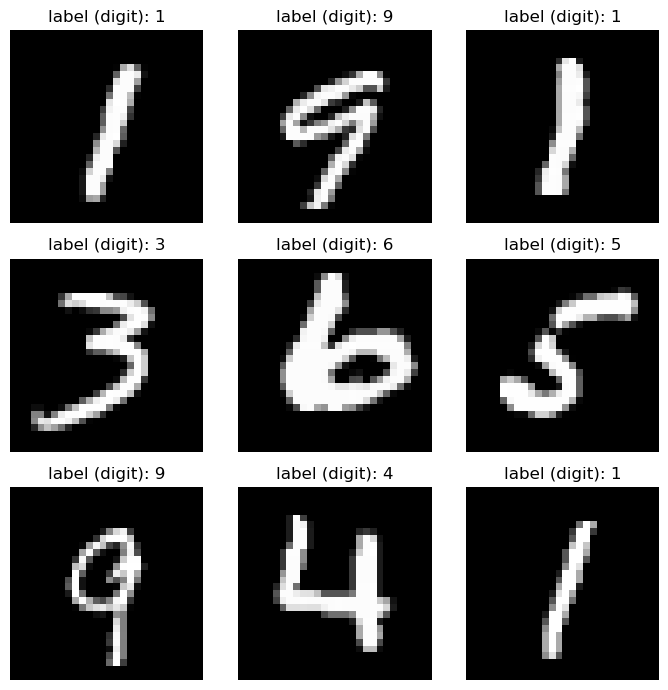

In [23]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
                                              + "Example_Image_Array"\
                                              + "_" + path_dict['run_label']

plotArrayImageExamples(data_tra,
                       num_row=3, num_col=3,
                       save_file=False,
                       object_index_start=0,
                       file_prefix=file_prefix,
                       file_location=path_dict['dir_data_figures'],
                       file_suffix=path_dict['file_figure_suffix'])

> Figure 1: Three rows of three images, each a handwritten number in white on a black background.

Plot the distributions of pixel values to understand the data further. All pixel data has been normalized, and pixels have values between 0 and 1 only.

The distribution of pixel values matches the images shown above: mostly black (values near 0) pixels, with some white (values near 1), and a few grey (values in between 0 and 1).

/tmp/ipykernel_5645/1158620559.py:58: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img_temp = np.array(img_temp).flat


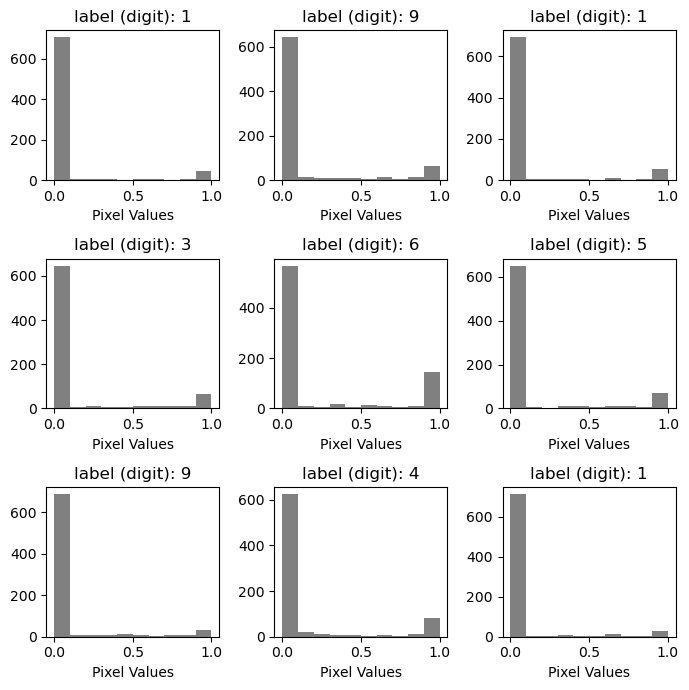

In [24]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
                                              + "Example_Histogram_Array"\
                                              + "_" + path_dict['run_label']

plotArrayHistogramExamples(data_tra,
                           num_row=3, num_col=3,
                           save_file=False,
                           file_prefix=file_prefix,
                           file_location=path_dict['dir_data_figures'],
                           file_suffix=path_dict['file_figure_suffix'])

> Figure 2: Three rows of three histograms, each showing the distribution of pixel values (number of pixels of a given value) for the handwritten digit images shown in Figure 1.

Examine the balance of classes in the data sets. If one class has more objects in the training set than other classes, the model will tend to be biased toward predicting that class. The classes don't have to be distributed perfectly uniformly, but a high degree of uniformity is preferable.

Use the `plotPredictionHistogram` function to plot histograms of true label distributions by class.

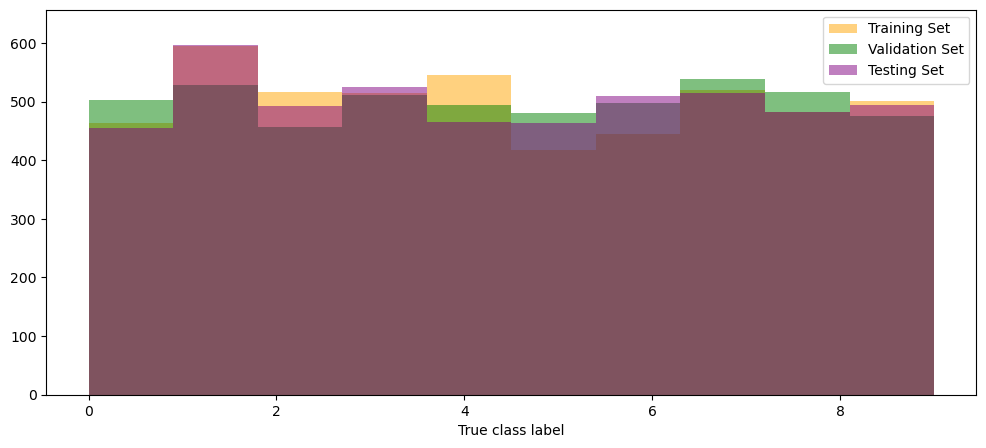

In [25]:
y_tra = []
y_val = []
y_tes = []

for i in np.arange(subset_size):
    image, label_tra = data_tra[i]
    image, label_val = data_val[i]
    image, label_tes = data_tes[i]
    y_tra.append(label_tra)
    y_val.append(label_val)
    y_tes.append(label_tes)

y_tra = np.array(y_tra)
y_val = np.array(y_val)
y_tes = np.array(y_tes)

file_prefix = path_dict['file_figure_prefix'] + "_"\
                                              + "Histograms_true_class"\
                                              + "_" + path_dict['run_label']

plotPredictionHistogram(y_tra,
                        y_prediction_b=y_val,
                        y_prediction_c=y_tes,
                        label_a="Training Set",
                        label_b="Validation Set",
                        label_c="Testing Set",
                        figsize=(12, 5),
                        alpha=0.5,
                        xlabel_plot="True class label",
                        file_prefix=file_prefix,
                        file_location=path_dict['dir_data_figures'],
                        file_suffix=path_dict['file_figure_suffix'])

**Figure 3**: The histograms of true class labels for each data set. Each histogram is for a different data set used during model training --- training data, validation data, and test data. Note that these are overlapping histograms, not stacked. Please compare to Figure 4, which shows histograms of the predicted class labels.

### 2.5. Create Dataloaders for training

Set the batch size, which will be used in dataloaders and in training. To simplify data-handling, we set the batch size to the size of the subset that we select. This means that there is one batch used in training.

In [26]:
batch_size = subset_size

Create dataloaders for the training, validation, and test set data loaders.

In [27]:
trainloader = torch.utils.data.DataLoader(data_tra, batch_size=batch_size,
                                          shuffle=False)

validloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size,
                                          shuffle=False)

testloader = torch.utils.data.DataLoader(data_tes, batch_size=batch_size,
                                         shuffle=False)

## 3. Train the model: Convolutional Neural Network

In this section, you will encounter the following major items for training a neural network:

1. basics of `pytorch` model-building;
2. defining the neural network model -- setting model hyperparameters, a glossary of terms of model architecture elements, glossary of terms for a network model class, creating a model class;
3. training the model.

### 3.1. Basics of pytorch

In `pytorch`, neural network models are defined as classes. This is slightly different than typical `tensorflow` usage, in which people build a `sequential` model or use a pre-built `model` class and add layers to that model. 

The other major difference between `pytorch` and `tensorflow` is the shape of the tensors and the inputs for each layer. 

In particular, in `pytorch` one has to explicitly match the output from one layer to the input of the next layer. Sometimes, this can be done with a calculation. But, more often, one must perform guess-and-check. <Explain this>

### 3.2. Define the neural network model

#### 3.2.1. Define model hyperparameters

Set the seed that for the random initial model weight values.

In [28]:
seed = 1729
new = torch.manual_seed(seed)

Define the loss function. We choose cross-entropy, which is the standard loss function for classification of discrete labels.

In [29]:
loss_fn = nn.CrossEntropyLoss()

#### 3.2.2. Glossary: model architecture elements

Below is a list of important terms for elements of a neural network architecture.

 * `activation function`: a function within a neuron that takes inputs from a previous layer and produces an output -- usually, this function is non-linear. Examples include "sigmoid," "softmax," and "reLu" (rectified linear unit).
 * `sigmoid`: an activation function that takes points from the Real line and maps them to the range [-1,1].
 * `softmax`: an activation function that takes points from the Real line and maps them to the range [0,1]. This can be used to obtain a 'probability score.'
 * `ReLU (rectified linear unit)`: an activation function that non-smoothly goes from 0 to some positive Real number when a threshold is reached for the input value. 
 * `weight`: the weight factor within an activation function.
 * `bias`: the bias factor applied after an activation function.
 * `layer`: one set of nodes/neurons that receive input data simultaneously.
 * `linear (Dense) layer`: occurs due to the "flattening" of a higher-dimensional data vector, like an image. It only has an activation function -- as opposed to a convolutional layer which makes a convolution operation.
 * `convolutional layer`: a layer that applies a convolution operation to an input sample.

#### 3.2.3. Glossary: class that defines a network model

Typically, there are two functions within this class.

The constructor function (`__init__`) defines the available layers of the network. These layers require specific settings related to the data set shapes. 
* `Conv2d`: defines a two-dimensional convolutional layer. Four inputs are considered here:
    * `in_channels` (required): the number of input channels.
    * `out_channels` (required): the number of output channels.
    * `kernel_size` (required): the size on one dimension of the convolutional kernel.
    * `stride` (optional): the stride of the convolution
* `Dropout`: defines a dropout layer. The fraction of neuron weights that are set to zero. Typically, this is used when the model is overfitting -- i.e., when the validation loss as a function of epoch is consistently higher than the training loss as a function of epoch (Please see Figure 6 as an example).
* `Linear`: defines a linear layer. Two inputs are considered here:
    * `in_features` (required): the size of the sample input to the layer.
    * `out_features` (required): the size of the sample output from the layer.

The function `forward` defines the order of operations during a forward pass of the model. During training, the `forward` function is applied to the input data to make predictions. After each round of predictions (epoch), the optimizer is engaged to take the difference between the true labels and the predicted labels and then use that difference to update the model weights. 

The `forward` function uses the layers defined in the constructor, as well as other layers that don't require inputs that depend on the data. These layers are defined in the `torch.nn.functional` submodule, which contains predefined functions for layers that operate directly on the data and don't require an instance of that layer. These `functional` layers are 
* `relu`: applies the `ReLU` activation function. It requires one input, the sample from the previous layer.
* `max_pool2d`: the max pooling function is applied to the sample from the previous layer. It requires the input sample and the size of the kernel of the pooling.
* `flatten`: reshapes the sample input into a one-dimensional tensor.

#### 3.2.4. Define the object class that represents the model 

In [30]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = x
        return output

Instantiate a neural network model object.

In [31]:
model = ConvNet()

Define the device. This is important especially when a GPU is available. This is necessary because the model and the data get moved to that device.

In our case, the device is a CPU because that's what is currently available on the RSP.

In [32]:
device = torch.device('cuda') if torch.cuda.is_available()\
    else torch.device('cpu')

Put the model on the device where the computations will be performed.

When placing the model on the device, it also shows a summary of the network architecture. Examine the shapes of the layers and the number of parameters in each layer. Too few parameters may prevent the model from being flexible enough to model the data. Too many parameters could lead to overfitting of the model (e.g., 'memorizing' the training data) and an unnecessarily high computational cost. Typically, models range from thousands to millions of parameters. There is an interplay between model size (number of parameters), the amount of training data, and the complexity of the images in the training data.

In [33]:
print("Model Summary:\n")
model.to(device)

Model Summary:



ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#### 3.2.5. Glossary: hyperparameters for the training schedule

* `learning rate`: A multiplicative factor defining the amount that the model weights will change in response to the size of the error (loss) in the model prediction for that epoch. The lower the learning rate, the smaller the change to the weights, and usually the longer it will take to train the model. However, if the learning rate is too high, the weights can change too quickly: then, the loss can fluctuate significantly and not decrease quickly.
* `momentum`: A multiplicative factor on the aggregate of previous gradients. This aggregate term is combined with the weight gradient term to define the total change in the value of the weights. The smaller the momentum, the lesser the influence of the aggregated gradients, and usually the longer it will take train the model.
* `optimizer`: The method/algorithm used to update the network weights. Stochastic Gradient Descent (SGD) is the most commonly used method.
* `epoch`: One loop of training the model. Each loop includes the entire data set (all the batches) once, and it includes at least one round of weight updates.
* `n_epochs`: The number of epochs to train the network.

#### 3.2.6. Assign hyperparameters for the training schedule

In [34]:
learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
n_epochs = 50

### 3.3. Train the model

Set the model into a training context. This ensures that layers like "batchnorm" and "dropout" will be activated. In contrast, when the model is set to an evaluation context (later in this tutorial), those layers will be deactivated.

In [35]:
%%capture
model.train()

Use a loop over epochs to incrementally optimize the network weight parameters. 

Use lists to track the loss values on the training data, the loss values on the testing data, and the accuracy values on the testing data. Define the "history" dictionary to hold those lists. We will visualize these later to study the fitting efficacy and generalization capacity of the network.

For this tutorial, 50 epochs on the medium-memory Rubin server required ~9 min of wall time and ~15min of CPU time.

In [36]:
%%time
time_start = time.time()

loss_train_list = []
loss_test_list = []
accuracy_test_list = []

for epoch in np.arange(n_epochs):

    loss_train = 0
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

    loss_train /= batch_size

    accuracy_test = 0
    loss_test = 0
    count_test = 0
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        accuracy_test += (torch.argmax(y_pred, 1) == labels).float().sum()
        loss_test += loss.item()
        count_test += len(labels)

    accuracy_test /= count_test
    loss_test /= batch_size

    loss_train_list.append(loss_train)
    loss_test_list.append(loss_test)
    accuracy_test_list.append(accuracy_test)

    # output = f"Epoch ({epoch:3d}):   accuracy ({accuracy_test*100:.2f} %),\
    output1 = f"Epoch ({epoch:2d}):   accuracy ({accuracy_test*50:.2f} %),  "
    output2 = f"train loss ({loss_train:.4f}),  valid loss ({loss_test:.4f})"
    output = output1 + output2
    print(output)

time_end = time.time()

time_difference = time_end - time_start

history = {"loss": loss_train_list,
           "val_loss": loss_test_list,
           "accuracy_test": accuracy_test_list}

print(f"Total training time: {time_difference/60.:2.4f} min")

Epoch ( 0):   accuracy (5.20 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 1):   accuracy (5.26 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 2):   accuracy (5.11 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 3):   accuracy (5.62 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 4):   accuracy (6.41 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 5):   accuracy (6.73 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 6):   accuracy (7.74 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 7):   accuracy (8.66 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 8):   accuracy (10.19 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 9):   accuracy (10.64 %),  train loss (0.0005),  valid loss (0.0005)
Epoch (10):   accuracy (11.37 %),  train loss (0.0005),  valid loss (0.0005)
Epoch (11):   accuracy (12.66 %),  train loss (0.0005),  valid loss (0.0005)
Epoch (12):   accuracy (12.65 %),  train loss (0.0005),  valid loss (0.0005)
Epoch (

Save model to file: "pt" is the common suffix used for pytorch model files. This saves the architecture and weights of the model.

In [37]:
file_prefix = path_dict['file_model_prefix'] + "_" + path_dict['run_label']
file_name_final = createFileName(file_prefix=file_prefix,
                                 file_location=path_dict['dir_data_model'],
                                 file_suffix=path_dict['file_model_suffix'],
                                 useuid=True,
                                 verbose=True)

torch.save(model.state_dict(), file_name_final)

/home/bnord/dp02_19a_temp/Models/Model_Run000_20251006_135655.pt


Load the model from a "pt" file.

In [38]:
%%capture
model.load_state_dict(torch.load(file_name_final, weights_only=False))

Set the model to evaluation mode so that the "batchnorm" and "dropout" layers are deactivated. This is necessary for consistent inference.

In [39]:
%%capture
model.eval()

## 4. Diagnosing the Results of Model Training

In this section, you will encounter the following items:

1. a glossary for diagnostics for model evaluation;
2. how to make predictions with the trained model;
3. basic bulk diagnostic: loss history;
4. basic bulk diagnostic: confusion matrix (CM);
5. basic bulk diagnostic: receiver operator characteristic (ROCH) curve;
6. investigating predictions of individual images.

### 4.1. Glossary: diagnostics and model evaluation

Use the following diagnostics to assess the status of the network optimization and efficacy. The [scikit-learn page on metrics and scoring](https://scikit-learn.org/stable/modules/model_evaluation.html) provides a good in-depth reference for these terms.

Model Predictions:
 * `Classification threshold`: The user-chosen value $[0,1]$ that sets the threshold for a positive classification. 
 * `Probability score`: The output from the classifier neural network. One typically uses the `softmax` activation function in the last layer of the NN to provide an output in the range $[0,1]$.
 * `Classification score`: The predicted class label is the class that received the highest probability score.

Metrics:
 * `Loss`: A function of the difference between the true labels and predicted labels.
 * `Accuracy`: A rough indicator of model training progress/convergence for balanced datasets. For model performance, use only in combination with other metrics. Avoid this metric when you have unbalanced training datasets. Consider using another metric.
 * `True Positive Rate (TPR; "Recall")`: Use when false negatives are more expensive than false positives.
 * `False Positive Rate (FPR)`: Use when false positives are more expensive than false negatives.
 * `Precision`: Use when positive predictions need to be accurate.

The `Generalization Error` (GE) is the difference in loss when the model is applied to training data versus when applied to validation and test data.

The `Confusion Matrix` (CM) is a visual representation of the classification accuracy. Each row is the set of predictions for each true value (with one true value per column). Values along the diagonal indicate true positives (correct predictions). Values below the diagonal indicate false positives. Values above the diagonal indicate false negatives. The optimal scenario is one in which the off-diagonal values are all zero.

The `Receiver Operator Characteristic (ROC) Curve` presents a comparison between the true positive rate (y-axis) and the false positive rate (x-axis) --- for a given false positive rate, the number of true positives that exist. Each point on the curve is for a distinct choice of the Classification threshold for the probability score $[0,1]$: the choice of classification threshold determines which objects are considered correctly classified. The optimal scenario is where the ROC curve is constant at a true positive rate $=1$. If the curve is along the diagonal (lower left to upper right), it indicates that the model performance is equivalent to 50-50 guessing.

### 4.2. Predict classifications with the trained model

Predict classification probabilities on the training, validation, and test sets. Produce both the probabilities of each digit and the top choice for each prediction.

In [40]:
y_prob_tes, y_choice_tes, y_true_tes, x_tes = predict(testloader, model,
                                                      "test")
y_prob_val, y_choice_val, y_true_val, x_val = predict(validloader, model,
                                                      "validation")
y_prob_tra, y_choice_tra, y_true_tra, x_tra = predict(trainloader, model,
                                                      "training")

test       data set ...             Accuracy: 85.8%, Avg loss: 0.494941
validation data set ...             Accuracy: 85.2%, Avg loss: 0.513865
training   data set ...             Accuracy: 85.9%, Avg loss: 0.481284


Print the shapes and verify that the shape of `y_prob_tes` matches the length of the input data `x_tes` and the number of classes. (as in Section 2.4).

In [41]:
print(f"The input data has the shape {np.shape(x_tes)}: there the {subset_size}\
 images each image has 28 pixels on a side.")
print(f"The predicted probability score array has the shape\
 {np.shape(y_prob_tes)}: there are {subset_size} predictions,\
 with 10 probability scores predicted for each input image.")
print(f"The predicted classes array has has the shape {np.shape(y_choice_tes)}:\
 there is one top choice (highest probability score) for each prediction.")

The input data has the shape (5000, 28, 28): there the 5000 images each image has 28 pixels on a side.
The predicted probability score array has the shape (5000, 10): there are 5000 predictions, with 10 probability scores predicted for each input image.
The predicted classes array has has the shape (5000,): there is one top choice (highest probability score) for each prediction.


Use the `plotPredictionHistogram` function to plot histograms of prediction distributions by class.

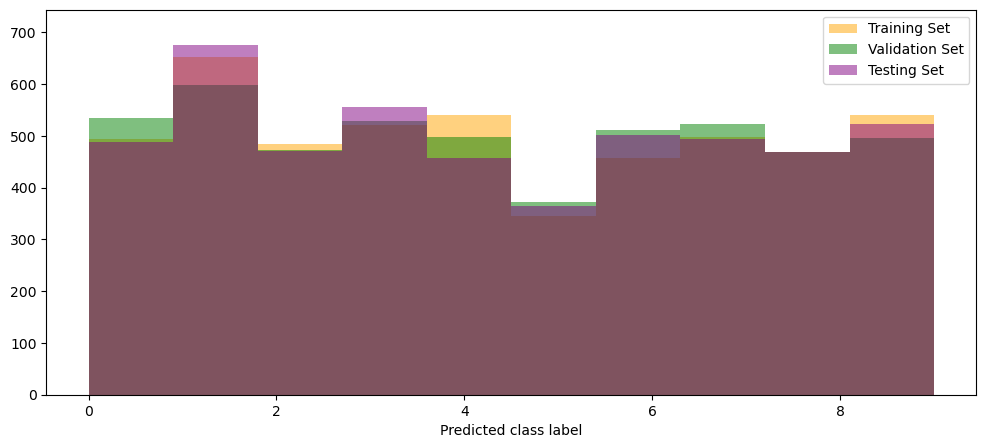

In [42]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
    + "Histograms_top_choice"\
    + "_" + path_dict['run_label']

plotPredictionHistogram(y_choice_tra,
                        y_prediction_b=y_choice_val,
                        y_prediction_c=y_choice_tes,
                        label_a="Training Set",
                        label_b="Validation Set",
                        label_c="Testing Set",
                        figsize=(12, 5),
                        alpha=0.5,
                        xlabel_plot="Predicted class label",
                        file_prefix=file_prefix,
                        file_location=path_dict['dir_data_figures'],
                        file_suffix=path_dict['file_figure_suffix'])

> Figure 4: Histograms of the number of images for which the top-choice class was each number 0 through 9. Each histogram is for a different data set used during model training --- training data, validation data, and test data. Note that these are overlapping histograms, not stacked. Please compare to Figure 3, which shows the distributions of true class labels for each data set. Consider which classes are represented differently between the true labels and the predicted labels.

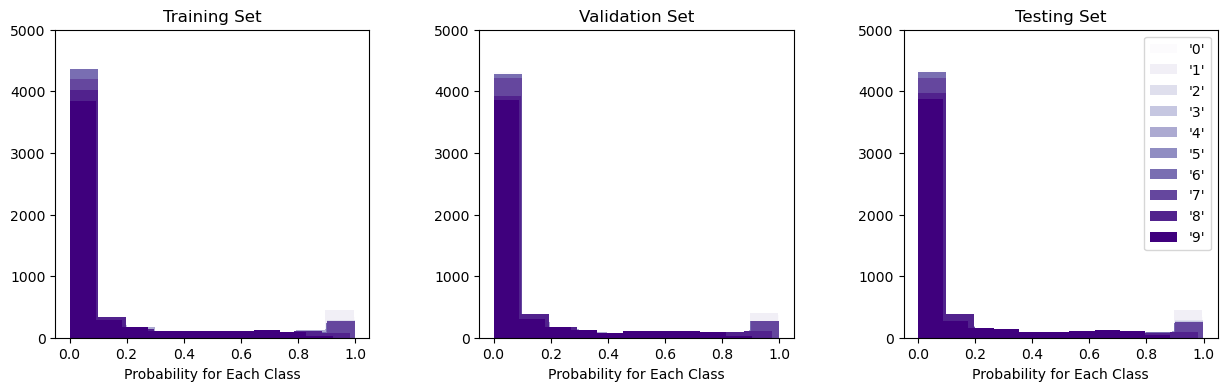

In [43]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
    + "Histograms_class_probabilities"\
    + "_" + path_dict['run_label']

plotPredictionHistogram(y_prob_tra,
                        y_prediction_b=y_prob_val,
                        y_prediction_c=y_prob_tes,
                        title_a='Training Set',
                        title_b='Validation Set',
                        title_c='Testing Set',
                        figsize=(15, 4),
                        file_prefix=file_prefix,
                        file_location=path_dict['dir_data_figures'],
                        file_suffix=path_dict['file_figure_suffix'])

> Figure 5: Histograms of the number of images (y-axis) that had a probability (x-axis) of being each class 0 through 9 (light to dark shades).

In both of Figure 3 and 4, the histograms show very similar shapes across the classification categories.
This is a good sign because it indicates the model is not heavily biased toward a particular class.

### 4.3. Loss History: History of Loss and Accuracy during Training

The primary task in optimizing a network is to minimize the Generalization Error. Plot the loss history for the validation and training sets. We reserve the test set for a 'blind' analysis.

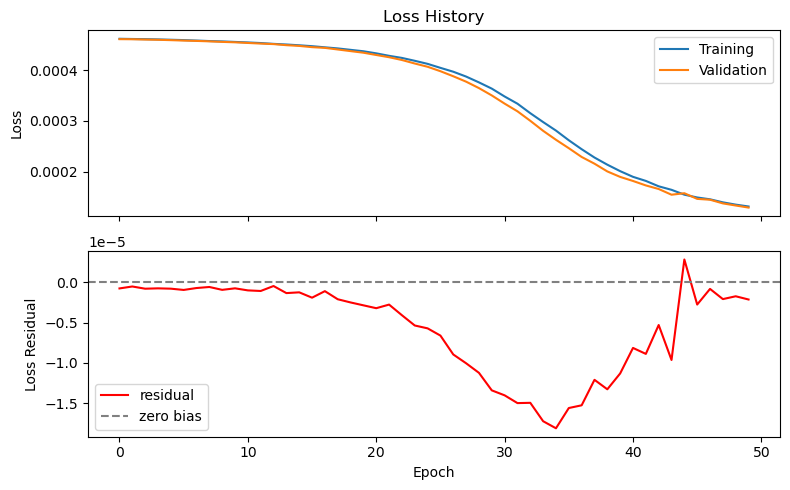

In [44]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
                                              + "LossHistory"\
                                              + "_"\
                                              + path_dict['run_label']

plotLossHistory(history,
                file_prefix=file_prefix,
                file_location=path_dict['dir_data_figures'],
                file_suffix=path_dict['file_figure_suffix'])

> Figure 6: The loss histories for the training and validation data sets and the loss residual history between the training and the validation set. Top panel: the loss history as a function of epoch for the training and validation sets decreases with time, as it should as the model fit improves. There is slight difference between the validation and the training. Bottom panel: the loss residual (validation loss minus training loss) shows a minimum near epoch 34, indicating the model-fitting underwent a divergence between the classifications, but that this was rectified in later epochs. For epochs 10 to 44, the difference between validation and training data indicates that the validation data may not have been represeentative of the training data.

Another pattern you may encounter is when the validation loss is consistently higher than the training loss. This typically indicates overfitting, which is when the model is complex enough to fit (sometimes, the term 'memorize' is used) all the details of the training data and not generalize enough to also fit the validation data.

### 4.4. Confusion Matrix: Bias in Trained Model?

Compute and plot the confusion matrices for the training, validation, and test samples (left, right, middle).

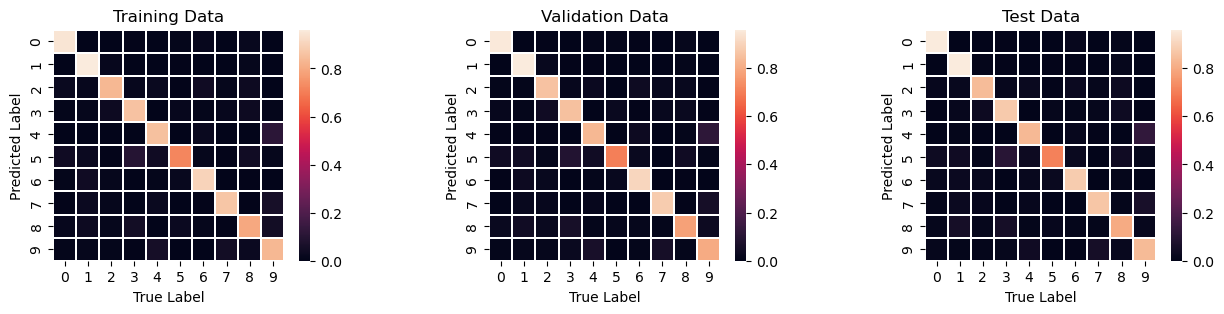

In [45]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
figsize = (15, 3)
linewidths = 0.01
linecolor = 'white'
ylabel = "Predicted Label"
xlabel = "True Label"

cm_tra = confusion_matrix(y_true_tra, y_choice_tra)
cm_val = confusion_matrix(y_true_val, y_choice_val)
cm_tes = confusion_matrix(y_true_tes, y_choice_tes)

df_cm_tra = pd.DataFrame(cm_tra / np.sum(cm_tra, axis=1)[:, None],
                         index=[i for i in classes],
                         columns=[i for i in classes])
df_cm_val = pd.DataFrame(cm_val / np.sum(cm_val, axis=1)[:, None],
                         index=[i for i in classes],
                         columns=[i for i in classes])
df_cm_tes = pd.DataFrame(cm_tes / np.sum(cm_tes, axis=1)[:, None],
                         index=[i for i in classes],
                         columns=[i for i in classes])

fig, (axa, axb, axc) = plt.subplots(1, 3, figsize=figsize)
fig.subplots_adjust(wspace=0.5)

ax1 = sns.heatmap(df_cm_tra, annot=False, linewidths=linewidths,
                  linecolor=linecolor, square=True, ax=axa)
_ = ax1.set(xlabel=xlabel, ylabel=ylabel, title="Training Data")

ax2 = sns.heatmap(df_cm_val, annot=False, linewidths=linewidths,
                  linecolor=linecolor, square=True, ax=axb)
_ = ax2.set(xlabel=xlabel, ylabel=ylabel, title="Validation Data")

ax3 = sns.heatmap(df_cm_tes, annot=False, linewidths=linewidths,
                  linecolor=linecolor, square=True, ax=axc)
_ = ax3.set(xlabel=xlabel, ylabel=ylabel, title="Test Data")

> Figure 7: Confusion matrices for the training, validation, and test data sets (left to right). Each cell in the matrix shows the fraction (see the color bars) of the total objects with that true label that have been predicted to be a given label. The diagonal represents images that were correctly classified. All off-diagonal cells represent false positives (lower left) or false negatives (upper right). Consider some examples. First, the class "0" is almost always predicted to be "0" with a lighter color in the top-most, left-most cell; all the other cells in the column are completely dark. Second, consider the cell that represents a prediction "4", when the true label is "9": that cell is not completely dark. A "4" has a similar morphology or shape as a "9."

### 4.5. Receiver Operator Characteristic (ROC) Curve: Trade-offs between Completeness and Purity

The Receiver Operator Characteristic (ROC) Curve is a plot of the True Positive Rate (TPR; y axis) versus the False Positive Rate (FPR; x axis).

For a given classification threshold on the probability (canonically, 0.5), the balance of true positives and false positives will change.

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be remove

/home/bnord/dp02_19a_temp/Figures/Figure_ROCCurve_Run000_20251006_135703.png


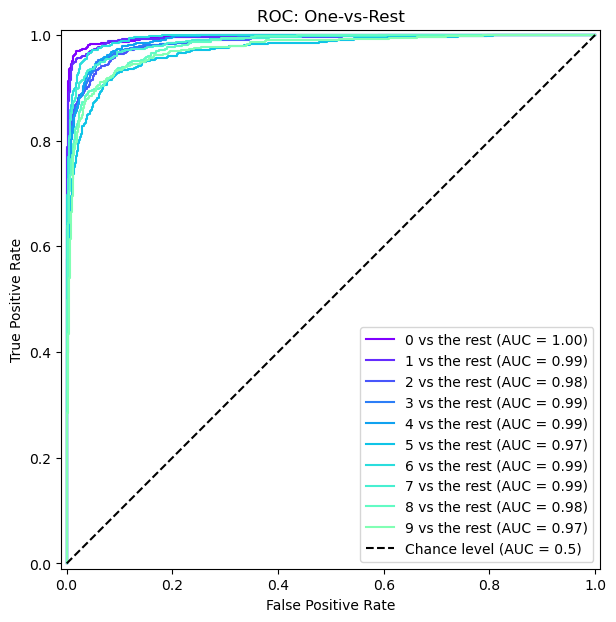

In [46]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
                                              + "ROCCurve"\
                                              + "_"\
                                              + path_dict['run_label']

plotROCMulticlassOnevsrest(y_tra, y_tes, y_prob_tes,
                              save_file=True,
                              file_prefix=file_prefix,
                              file_location=path_dict['dir_data_figures'],
                              file_suffix=path_dict['file_figure_suffix'])

> Figure 8: ROC curve for classification of one digit (class) against the remaining nine digits (classes). All of the curves show a very high AUC, which means near-perfect classification. The black dashed line shows an ROC curve representing a 50-50 guess. 

### 4.5. Investigating predictions in detail

#### 4.5.1. Glossary: classification metrics

Consider the example of true class label being "2". Then, we define the following metrics.

* `True Positive (TP)`: correctly classified input digit image --- e.g., a "2" classified as "2".
* `False Positive (FP)`: another digit classified as "2".
* `True Negative (TN)`: another digit classified as another digit.
* `False Negative (FN)`: a "2" classified as something other than "2".

#### 4.5.2. Explore the classification of the training data for an example class value

Investigate the case in which the true digit label is "2".

In [47]:
class_value = 2

Find all objects that have that class value. Obtain indices for the TP's, FP's, TN's, and FN's. Create subsets of the data according to those indices.

In [48]:
ind_class_tp_tra = np.where((y_true_tra == class_value)
                            & (y_choice_tra == class_value))[0]

ind_class_fp_tra = np.where((y_true_tra != class_value)
                            & (y_choice_tra == class_value))[0]

ind_class_tn_tra = np.where((y_true_tra != class_value)
                            & (y_choice_tra != class_value))[0]

ind_class_fn_tra = np.where((y_true_tra == class_value)
                            & (y_choice_tra != class_value))[0]

x_tra_tp = x_tra[ind_class_tp_tra]
y_true_tra_tp = y_true_tra[ind_class_tp_tra]
y_choice_tra_tp = y_choice_tra[ind_class_tp_tra]

x_tra_fp = x_tra[ind_class_fp_tra]
y_true_tra_fp = y_true_tra[ind_class_fp_tra]
y_choice_tra_fp = y_choice_tra[ind_class_fp_tra]

x_tra_tn = x_tra[ind_class_tn_tra]
y_true_tra_tn = y_true_tra[ind_class_tn_tra]
y_choice_tra_tn = y_choice_tra[ind_class_tn_tra]

x_tra_fn = x_tra[ind_class_fn_tra]
y_true_tra_fn = y_true_tra[ind_class_fn_tra]
y_choice_tra_fn = y_choice_tra[ind_class_fn_tra]

n_tp = len(ind_class_tp_tra)
n_fp = len(ind_class_fp_tra)
n_tn = len(ind_class_tn_tra)
n_fn = len(ind_class_fn_tra)

print(f"TP count: {n_tp:4d}")
print(f"FP count: {n_fp:4d}")
print(f"TN count: {n_tn:4d}")
print(f"FN count: {n_fn:4d}")

TP count:  430
FP count:   54
TN count: 4430
FN count:   86


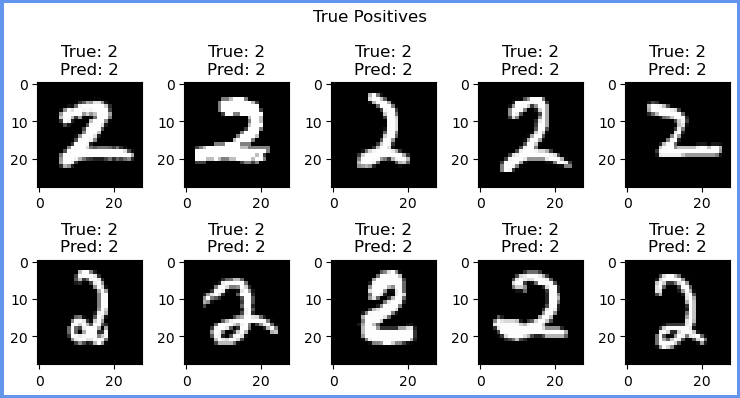

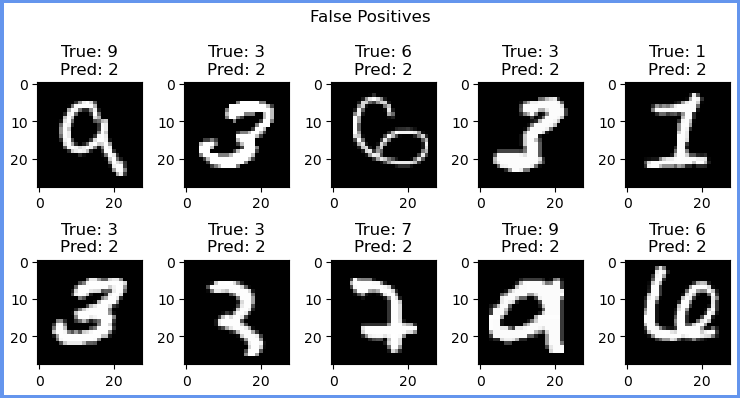

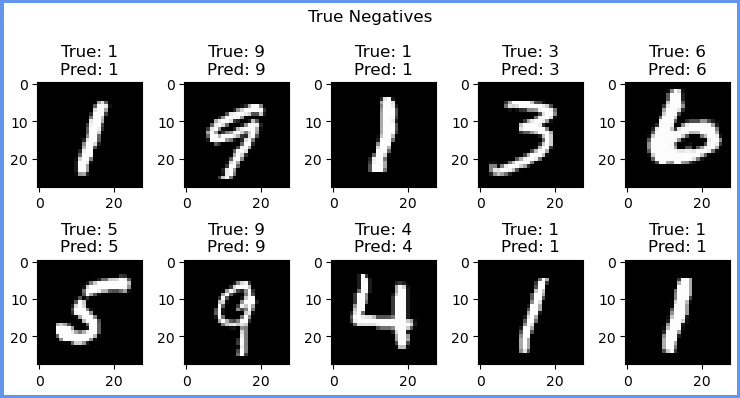

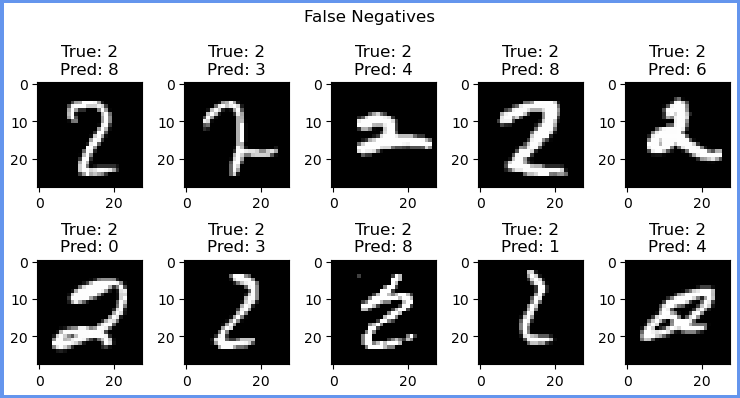

In [49]:
if n_tp > 0:
    file_prefix = path_dict['file_figure_prefix'] + "_"\
        + "ExampleImages_TruePostives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayImageConfusion(x_tra_tp,
                            y_true_tra_tp,
                            y_choice_tra_tp,
                            title_main="True Positives",
                            num=10,
                            file_prefix=file_prefix,
                            file_location=path_dict['dir_data_figures'],
                            file_suffix=path_dict['file_figure_suffix'])

if n_fp > 0:
    file_prefix = path_dict['file_figure_prefix'] + "_"\
        + "ExampleImages_FalsePostives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayImageConfusion(x_tra_fp,
                            y_true_tra_fp,
                            y_choice_tra_fp,
                            title_main="False Positives",
                            num=10,
                            file_prefix=file_prefix,
                            file_location=path_dict['dir_data_figures'],
                            file_suffix=path_dict['file_figure_suffix'])

if n_tn > 0:
    file_prefix = path_dict['file_figure_prefix'] + "_"\
        + "ExampleImages_TrueNegatives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayImageConfusion(x_tra_tn,
                            y_true_tra_tn,
                            y_choice_tra_tn,
                            title_main="True Negatives",
                            num=10,
                            file_prefix=file_prefix,
                            file_location=path_dict['dir_data_figures'],
                            file_suffix=path_dict['file_figure_suffix'])

if n_fn > 0:
    file_prefix = path_dict['file_figure_prefix'] + "_"\
        + "ExampleImages_FalseNegatives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayImageConfusion(x_tra_fn,
                            y_true_tra_fn,
                            y_choice_tra_fn,
                            title_main="False Negatives",
                            num=10,
                            file_prefix=file_prefix,
                            file_location=path_dict['dir_data_figures'],
                            file_suffix=path_dict['file_figure_suffix'])

> Figure 9: Four panels of 10 images each, representing true positives (top), false positives (second), true negatives (third), and false negatives (bottom), for classification category 2.


Plot histograms of images pixels of true positives, false positives, true negatives, and false negatives.

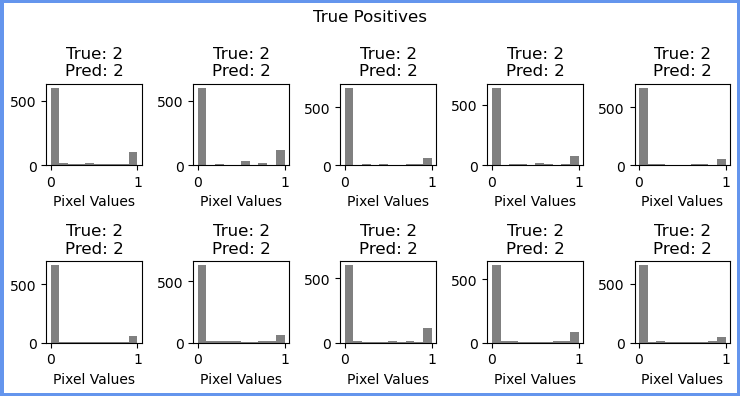

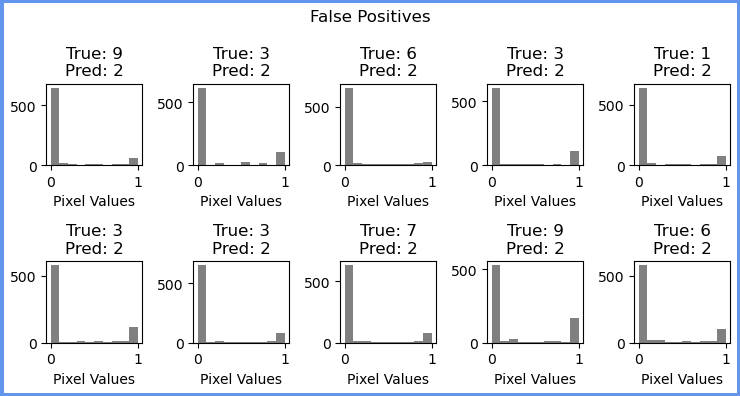

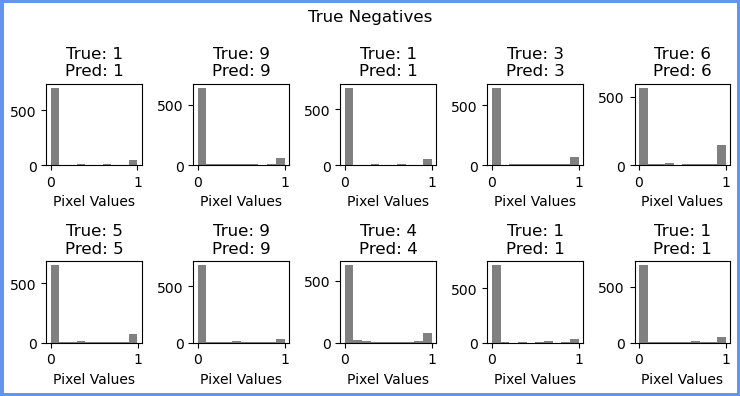

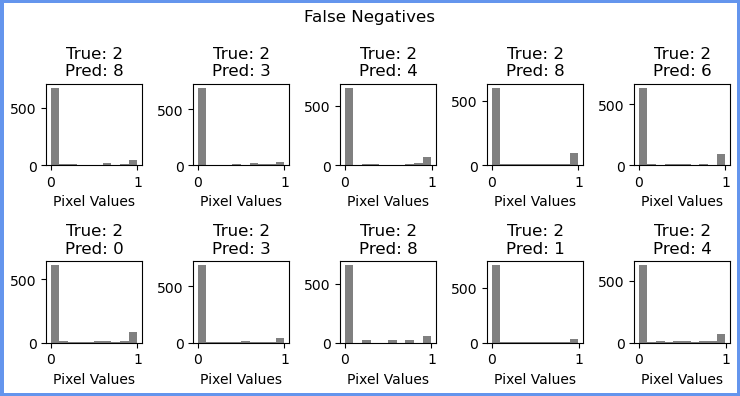

In [50]:
if n_tp > 0:
    file_prefix = path_dict['file_figure_prefix']\
        + "_" + "ExampleImages_TruePostives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayHistogramConfusion(x_tra_tp,
                                y_true_tra_tp,
                                y_choice_tra_tp,
                                title_main="True Positives",
                                num=10,
                                file_prefix=file_prefix,
                                file_location=path_dict['dir_data_figures'],
                                file_suffix=path_dict['file_figure_suffix'])

if n_fp > 0:
    file_prefix = path_dict['file_figure_prefix']\
        + "_" + "ExampleImages_FalsePostives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayHistogramConfusion(x_tra_fp,
                                y_true_tra_fp,
                                y_choice_tra_fp,
                                title_main="False Positives",
                                num=10,
                                file_prefix=file_prefix,
                                file_location=path_dict['dir_data_figures'],
                                file_suffix=path_dict['file_figure_suffix'])

if n_tn > 0:
    file_prefix = path_dict['file_figure_prefix']\
        + "_" + "ExampleImages_TrueNegatives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayHistogramConfusion(x_tra_tn,
                                y_true_tra_tn,
                                y_choice_tra_tn,
                                title_main="True Negatives",
                                num=10,
                                file_prefix=file_prefix,
                                file_location=path_dict['dir_data_figures'],
                                file_suffix=path_dict['file_figure_suffix'])

if n_fn > 0:
    file_prefix = path_dict['file_figure_prefix']\
        + "_" + "ExampleImages_FalseNegatives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayHistogramConfusion(x_tra_fn,
                                y_true_tra_fn,
                                y_choice_tra_fn,
                                title_main="False Negatives",
                                num=10,
                                file_prefix=file_prefix,
                                file_location=path_dict['dir_data_figures'],
                                file_suffix=path_dict['file_figure_suffix'])

> Figure 10: Histograms of the pixel flux values for the images shown in Figure 8. Here, it is difficult to infer reasons for network classification errors like false positives and false negatives. If it is expected that a particular would have a particular distribution of pixel brightnesses, but the histogram for the predicted digit has a different distribution, that may help you identify a pattern. This may be a more useful diagnostic for physics-related data, like galaxy light profiles.

#### 4.5.3. Investigate morphological features of images with feature maps

The last diagnostic of this tutorial is the `feature map`, which shows how that one layer affects or processes the input image after the weights have been set during the model training. The morphological elements in the feature maps are the image regions that are highlighed by the earliest layers of convolution and activation functions.

The feature map is obtained by passing an input image through one layer of the trained neural network model. More specifically, we first choose an input datum (image) by setting the array index of interest. Then, we make the image a `tensor` with the appropriate number of dimensions using `unsqueeze`. Then, we transfer it to the `device`. Next, we choose the `conv1` layer defined the section above where we defined the `model`. Finally, we use the number of convolutional kernels (32) that exist in the `conv1` layer of the model. 

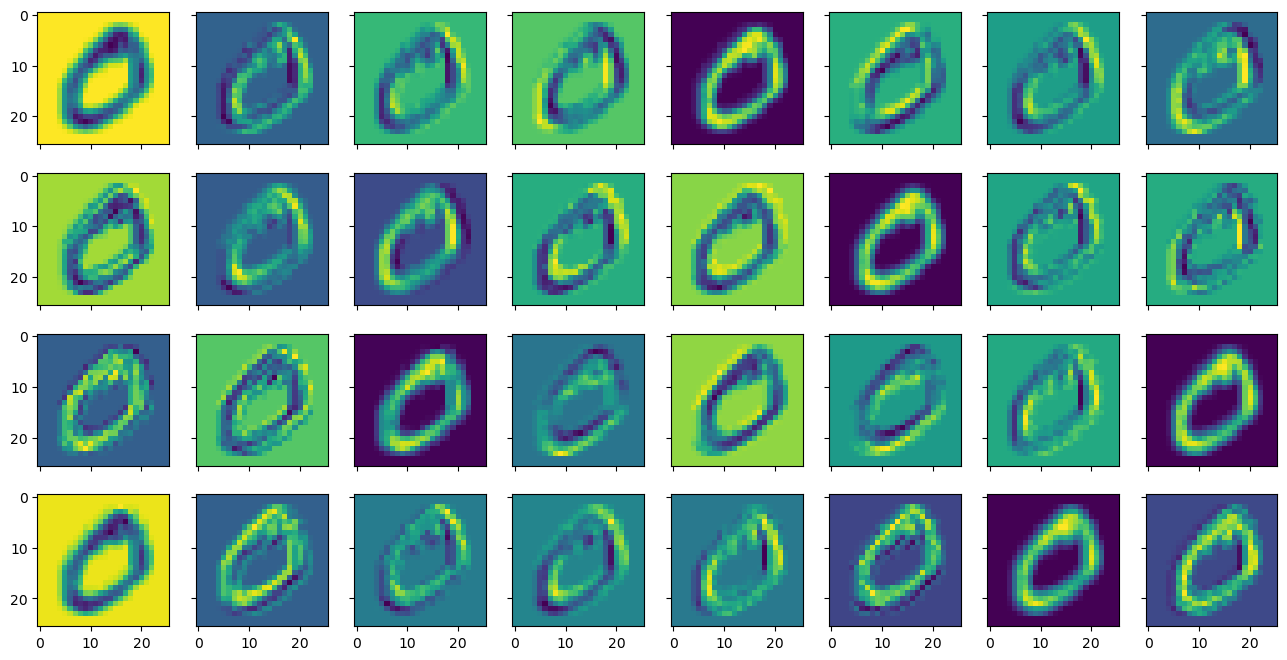

In [51]:
index_input_image = 1
number_conv_kernels = 32

input_image = dataset.data[index_input_image].type(torch.float32)
input_image = input_image.clone().detach()
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)

with torch.no_grad():
    feature_maps = model.conv1(input_image).cpu()

fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16, 8))

for i in range(0, number_conv_kernels):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[i])

plt.show()

> Figure 11: `Feature maps` of one input from the `conv1` layer of the `model`. The units on the x- and y-axes are the pixel indices. There are 32 images because there are 32 convolutional kernels in the `conv1` layer.
>
> The feature maps derived from the trained model show which morphological features --- e.g., lines and edges --- are favored by the model. When the model is accurate, these features and feature maps will accurately reflect the input image. In this example, the handwritten digit is "0," and the feature maps all appear as "0's". Some maps have more clearly defined edges and "0"-like features than others, because each convolutional kernel has a distinct weight parameter associated with it. 

## 5. Exercises for the Learner

Each time you train a new model, re-run all the diagnostic plots.

1. How do the loss and accuracy histories change when batch size is small or large? Why?
2. Does the NN take more or less time (more or fewer epochs) to converge if the input image data are normalized or not normalized? Why?
3. How does the size of the training set affect the model's accuracy and loss -- keeping the number of epochs the same? Why?
3. How does the random seed for the weight initialization affect the model's accuracy and loss -- keeping the number of epochs the same?
5. Increase and then decrease the number of weights in the NN by an order of magnitude. Train the NN for each of those models and record the times. How does the number of weights in the neural network affect the training time and model loss and accuracy?
6. Increase and then decrease the number of layers in the NN. Train the NN for each of those models and record the times. How does the number of weights in the neural network affect the training time and model loss and accuracy?
7. Make new ROC curves using the validation data and the training data. Are the results consistent with those from the test data?
8. Change the pytorch random seed, and re-run the training and model evaluation. Have the results changed?